# H2O AutoML Binary Classification Demo

adapted from
https://github.com/h2oai/h2o-tutorials/blob/master/h2o-world-2017/automl/Python/automl_binary_classification_product_backorders.ipynb

### Start H2O

Import the **h2o** Python module and `H2OAutoML` class and initialize a local H2O cluster.

In [1]:
import sys, os, time
import matplotlib.pyplot as plt

In [2]:
import h2o
from h2o.automl import H2OAutoML

In [3]:
# start H2O - may take ~20 sec
h2o.init(max_mem_size=16)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_333"; Java(TM) SE Runtime Environment (build 1.8.0_333-b02); Java HotSpot(TM) 64-Bit Server VM (build 25.333-b02, mixed mode)
  Starting server from /Users/levselector/miniconda3/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/6g/71ky449s1l51pgvr_kb7tb980000gn/T/tmps2qgusqh
  JVM stdout: /var/folders/6g/71ky449s1l51pgvr_kb7tb980000gn/T/tmps2qgusqh/h2o_levselector_started_from_python.out
  JVM stderr: /var/folders/6g/71ky449s1l51pgvr_kb7tb980000gn/T/tmps2qgusqh/h2o_levselector_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_levselector_rkx6yq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,14.22 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


### Load Data

For the AutoML binary classification demo, we use a subset of the [Product Backorders](https://www.kaggle.com/tiredgeek/predict-bo-trial/data) dataset.  The goal here is to predict whether or not a product will be put on backorder status, given a number of product metrics such as current inventory, transit time, demand forecasts and prior sales.

In [4]:
t1_cell = time.time()
# Use local data file or download from GitHub
fname = "product_backorders.csv"
if os.path.isfile(fname):
    print("reading local file", fname)
    df = h2o.import_file(fname)
else:
    url = "https://github.com/h2oai/h2o-tutorials/raw/master/h2o-world-2017/automl/data/" + fname
    print("reading file from URL\n", url)
    df = h2o.import_file(url)
    df.as_data_frame().to_csv(fname,sep=",",index=False)

# Load data into H2O
print("Wall time: %.3f s" % (time.time()-t1_cell))

reading file from URL
 https://github.com/h2oai/h2o-tutorials/raw/master/h2o-world-2017/automl/data/product_backorders.csv
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Wall time: 7.695 s


For classification, the response should be encoded as categorical (aka. "factor" or "enum"). Let's take a look.

In [5]:
df.describe()

Rows:19053
Cols:23




,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
type,int,int,int,int,int,int,int,int,int,int,int,int,enum,int,real,real,int,enum,enum,enum,enum,enum,enum
mins,1111620.0,-1440.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.0,-99.0,-99.0,0.0,,,,,,
mean,2059552.760562641,376.36702881436,7.706036161335188,48.272345562378625,182.9108276911773,344.73983099774307,497.79242114102766,56.11887891670603,168.53445651603428,333.5321996535979,504.25539285151945,48.8407075001312,,2.311499501390858,-6.519833622001784,-6.05393533826694,0.8917755734005142,,,,,,
maxs,3284775.0,730722.0,52.0,170920.0,479808.0,967776.0,1418208.0,186451.0,550609.0,1136154.0,1759152.0,85584.0,,13824.0,1.0,1.0,1440.0,,,,,,
sigma,663337.6456498677,7002.071628662685,6.7786650721241895,1465.9992102068286,4304.865591970626,8406.062155159245,12180.570042918358,1544.217777548255,4581.340080221506,9294.566153218982,14184.145395653622,968.7738680675268,,110.24106014611982,25.975138766871872,25.18449715003253,23.033345417338797,,,,,,
zeros,0,1858,121,15432,12118,11136,10604,10278,8022,6864,6231,9909,,18601,474,401,18585,,,,,,
missing,0,0,1078,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1113121.0,0.0,8.0,1.0,6.0,6.0,6.0,0.0,4.0,9.0,12.0,0.0,No,1.0,0.9,0.89,0.0,No,No,No,Yes,No,Yes
1,1113268.0,0.0,8.0,0.0,2.0,3.0,4.0,1.0,2.0,3.0,3.0,0.0,No,0.0,0.96,0.97,0.0,No,No,No,Yes,No,Yes
2,1113874.0,20.0,2.0,0.0,45.0,99.0,153.0,16.0,42.0,80.0,111.0,10.0,No,0.0,0.81,0.88,0.0,No,No,No,Yes,No,Yes


We will notice that the response column, `"went_on_backorder"`, is already encoded as "enum", so there's nothing we need to do here.  If it were encoded as a 0/1 "int", then we'd have to convert the column as follows:  `df[y] = df[y].asfactor()`


Next, let's identify the response & predictor columns by saving them as `x` and `y`.  The `"sku"` column is a unique identifier so we'll want to remove that from the set of our predictors.

In [6]:
y = "went_on_backorder"
x = df.columns
x.remove(y)
x.remove("sku")

## Run AutoML 

Run AutoML, stopping after 10 models.  The `max_models` argument specifies the number of individual (or "base") models, and does not include the two ensemble models that are trained at the end.

In [7]:
t1_cell = time.time()

include_algos = ["DRF","XGBoost","StackedEnsemble","GBM"]
exclude_algos = ["GLM", "DeepLearning"]

aml = H2OAutoML(max_models = 10, 
                seed = 1, 
                max_runtime_secs = 2400,
                # include_algos = include_algos,
                exclude_algos = exclude_algos)
aml.train(x = x, y = y, training_frame = df)
print("Wall time: %.3f s" % (time.time()-t1_cell))

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Wall time: 105.457 s


*Note: If you see the following error, it means that you need to install the pandas module.*
```
H2OTypeError: Argument `python_obj` should be a None | list | tuple | dict | numpy.ndarray | pandas.DataFrame | scipy.sparse.issparse, got H2OTwoDimTable 
``` 

## Leaderboard

Next, we will view the AutoML Leaderboard.  Since we did not specify a `leaderboard_frame` in the `H2OAutoML.train()` method for scoring and ranking the models, the AutoML leaderboard uses cross-validation metrics to rank the models.  

A default performance metric for each machine learning task (binary classification, multiclass classification, regression) is specified internally and the leaderboard will be sorted by that metric.  In the case of binary classification, the default ranking metric is Area Under the ROC Curve (AUC).  In the future, the user will be able to specify any of the H2O metrics so that different metrics can be used to generate rankings on the leaderboard.

The leader model is stored at `aml.leader` and the leaderboard is stored at `aml.leaderboard`.

In [8]:
lb = aml.leaderboard

Now we will view a snapshot of the top models.  Here we should see the two Stacked Ensembles at or near the top of the leaderboard.  Stacked Ensembles can almost always outperform a single model.

In [9]:
lb.head(100)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_1_AutoML_1_20220709_213846,0.952354,0.167639,0.755777,0.144183,0.222998,0.0497282
StackedEnsemble_BestOfFamily_1_AutoML_1_20220709_213846,0.951799,0.168523,0.754148,0.150858,0.223516,0.0499592
GBM_4_AutoML_1_20220709_213846,0.94803,0.174279,0.738898,0.151697,0.226997,0.0515278
GBM_1_AutoML_1_20220709_213846,0.947494,0.175499,0.736207,0.155024,0.228953,0.0524196
XGBoost_3_AutoML_1_20220709_213846,0.946677,0.175721,0.736699,0.152125,0.22783,0.0519064
GBM_3_AutoML_1_20220709_213846,0.945515,0.178002,0.729425,0.152024,0.228956,0.0524209
XGBoost_2_AutoML_1_20220709_213846,0.944668,0.180967,0.727345,0.169612,0.23026,0.0530196
GBM_2_AutoML_1_20220709_213846,0.944605,0.180058,0.725547,0.156582,0.23011,0.0529504
XGBoost_1_AutoML_1_20220709_213846,0.944324,0.18062,0.723453,0.159076,0.229847,0.0528299
GBM_5_AutoML_1_20220709_213846,0.941297,0.184735,0.718737,0.149194,0.232521,0.0540659


To view the entire leaderboard, specify the `rows` argument of the `head()` method as the total number of rows:

In [10]:
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_1_AutoML_1_20220709_213846,0.952354,0.167639,0.755777,0.144183,0.222998,0.0497282
StackedEnsemble_BestOfFamily_1_AutoML_1_20220709_213846,0.951799,0.168523,0.754148,0.150858,0.223516,0.0499592
GBM_4_AutoML_1_20220709_213846,0.94803,0.174279,0.738898,0.151697,0.226997,0.0515278
GBM_1_AutoML_1_20220709_213846,0.947494,0.175499,0.736207,0.155024,0.228953,0.0524196
XGBoost_3_AutoML_1_20220709_213846,0.946677,0.175721,0.736699,0.152125,0.22783,0.0519064
GBM_3_AutoML_1_20220709_213846,0.945515,0.178002,0.729425,0.152024,0.228956,0.0524209
XGBoost_2_AutoML_1_20220709_213846,0.944668,0.180967,0.727345,0.169612,0.23026,0.0530196
GBM_2_AutoML_1_20220709_213846,0.944605,0.180058,0.725547,0.156582,0.23011,0.0529504
XGBoost_1_AutoML_1_20220709_213846,0.944324,0.18062,0.723453,0.159076,0.229847,0.0528299
GBM_5_AutoML_1_20220709_213846,0.941297,0.184735,0.718737,0.149194,0.232521,0.0540659


In [11]:
df = lb.as_data_frame()
df.to_csv("leader_board_XGB_DRF.csv", sep=',')

## Ensemble Exploration

To understand how the ensemble works, let's take a peek inside the Stacked Ensemble "All Models" model.  The "All Models" ensemble is an ensemble of all of the individual models in the AutoML run.  This is often the top performing model on the leaderboard.

In [12]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])

/Users/levselector/miniconda3/lib/python3.9/site-packages/h2o/estimators/stackedensemble.py:925: H2ODeprecationWarning: The usage of stacked_ensemble.metalearner()['name'] will be deprecated. Metalearner now returns the metalearner object. If you need to get the 'name' please use stacked_ensemble.metalearner().model_id
  warnings.warn(


In [13]:
type(metalearner)

h2o.estimators.glm.H2OGeneralizedLinearEstimator

Examine the variable importance of the metalearner (combiner) algorithm in the ensemble.  This shows us how much each base learner is contributing to the ensemble. The AutoML Stacked Ensembles use the default metalearner algorithm (GLM with non-negative weights), so the variable importance of the metalearner is actually the standardized coefficient magnitudes of the GLM. 

In [14]:
mydict = metalearner.coef_norm()
mydict

{'Intercept': -3.7603769443044803,
 'GBM_4_AutoML_1_20220709_213846': 0.600338870537741,
 'GBM_1_AutoML_1_20220709_213846': 0.21047214734874384,
 'XGBoost_3_AutoML_1_20220709_213846': 0.4524633779239384,
 'GBM_3_AutoML_1_20220709_213846': 0.0,
 'XGBoost_2_AutoML_1_20220709_213846': 0.396122661088763,
 'GBM_2_AutoML_1_20220709_213846': 0.0,
 'XGBoost_1_AutoML_1_20220709_213846': 0.24356766606984886,
 'GBM_5_AutoML_1_20220709_213846': 0.0,
 'XRT_1_AutoML_1_20220709_213846': 0.4062178750483362,
 'DRF_1_AutoML_1_20220709_213846': 0.18295931287538045}

We can also plot the base learner contributions to the ensemble.

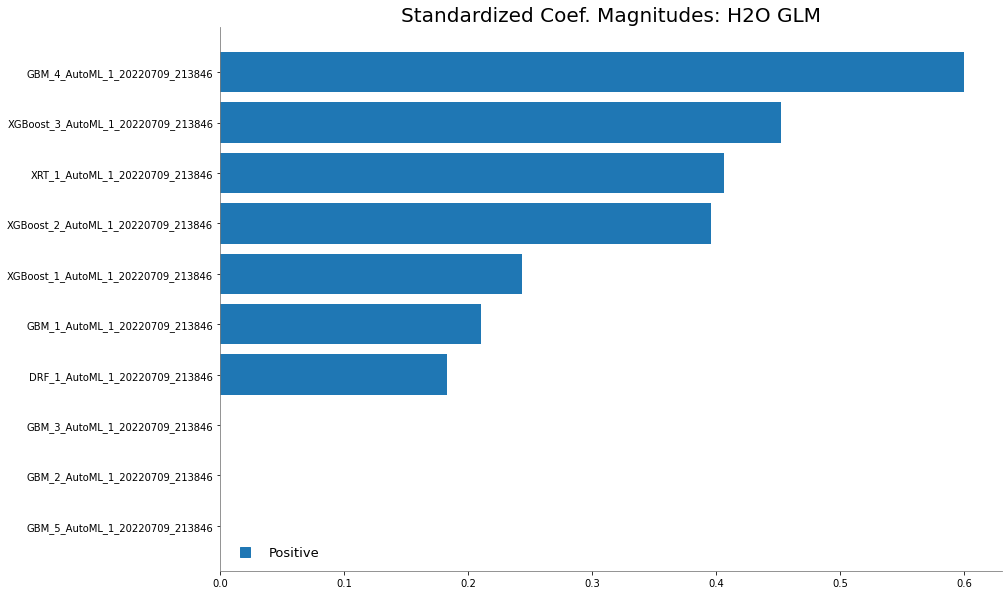

In [15]:
# %matplotlib inline
metalearner.std_coef_plot()

## Save Leader Model

There are two ways to save the leader model -- binary format and MOJO format.  If you're taking your leader model to production, then we'd suggest the MOJO format since it's optimized for production use.

In [16]:
h2o.save_model(aml.leader, path = "./product_backorders_model_bin")

'/Users/levselector/Documents/GitHub/notebooks/product_backorders_model_bin/StackedEnsemble_AllModels_1_AutoML_1_20220709_213846'

In [17]:
aml.leader.download_mojo(path = "./")

'/Users/levselector/Documents/GitHub/notebooks/StackedEnsemble_AllModels_1_AutoML_1_20220709_213846.zip'